In [1]:
import time
start_time=time.time()

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lmfit
from scipy import interpolate
import pickle

from bfunc import bfunc00,bfunc01,bfunc02

Data load and region parameters

In [3]:
name = 'HX'

In [4]:
reg = 'HX'

In [5]:
pickle_in = open('SFresults//' + name + '.pkl',"rb")
SFresults = pickle.load(pickle_in)

In [6]:
B = SFresults['b2']
r = SFresults['s']
s0 = SFresults['s0']   
m = SFresults['m'] 
sig2 = SFresults['sig2'] 
r0 = SFresults['r0'] 
noise = B.mean()*0.05

In [7]:
model02 = lmfit.Model(bfunc02)
model02.param_names

['r0', 'sig2', 'm', 's0', 'noise']

In [8]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[r > r0] /= 2.0

In [9]:
for p in model02.param_names:
    model02.set_param_hint(p, min=0.0)
#model02.set_param_hint("sig2", value=sig2, vary=False)
#model02.set_param_hint("s0", min=0.2)
model02.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
m           nan        0      inf     True    
noise       nan        0      inf     True    
r0          nan        0      inf     True    
s0          nan        0      inf     True    
sig2        nan        0      inf     True    


In [10]:
result2 = model02.fit(
    B, 
    weights=weights,
    r = r, r0 = r0, m = m, s0 = s0, noise = noise, sig2=sig2,
)

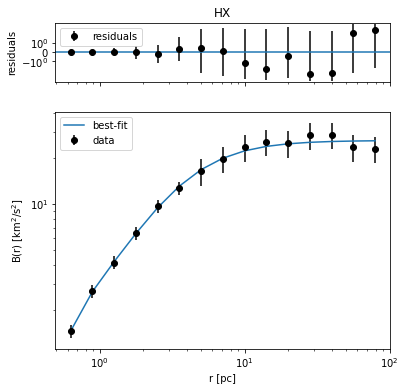

In [11]:
fig, _ = result2.plot( 'ko')
fig.axes[0].set(
    title=reg,
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale = "log",
    yscale = "log",
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
);

plt.savefig('Imgs//SF//' + reg + '.pdf', bbox_inches='tight')



In [12]:
CIresults = {'resultCI' : result2,
            'Rmax/r0' : r.max()/result2.params['r0'].value,
            'lT' : (r[3]/2**0.5)*((result2.params['r0'].value/r[3])**(result2.params['m'].value/2))
          }

In [13]:
f = open('CIresults//' + name +'.pkl',"wb")
pickle.dump(CIresults,f)
f.close()

In [14]:
print(result2.fit_report())

[[Model]]
    Model(bfunc02)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 15
    # variables        = 5
    chi-square         = 1.47372792
    reduced chi-square = 0.14737279
    Akaike info crit   = -24.8038251
    Bayesian info crit = -21.2635741
[[Variables]]
    r0:     3.64648711 +/- 0.21627708 (5.93%) (init = 3.581718)
    sig2:   12.7759470 +/- 0.99324036 (7.77%) (init = 12.89595)
    m:      1.72429905 +/- 0.25836453 (14.98%) (init = 1.5)
    s0:     0.29325400 +/- 0.17368662 (59.23%) (init = 0.9263956)
    noise:  0.66904003 +/- 1.28764399 (192.46%) (init = 0.8403742)
[[Correlations]] (unreported correlations are < 0.100)
    C(s0, noise)   =  0.995
    C(m, noise)    =  0.962
    C(m, s0)       =  0.940
    C(sig2, m)     = -0.926
    C(sig2, noise) = -0.897
    C(sig2, s0)    = -0.882
    C(r0, s0)      =  0.492
    C(r0, noise)   =  0.458
    C(r0, m)       =  0.239


In [15]:
for p in result2.model.param_names:
    result2.params[p].stderr = result2.params[p].value * 0.1

In [16]:
result2.conf_interval()
print(result2.ci_report())

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=5.903657909241403e-06 < 1e-05 at iteration 7 and prob(s0=0.08797619990250755) = 0.8870487438008804 < max(sigmas).
  warn(errmsg)
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:312: UserWarning: Bound reached with prob(noise=0.0) = 0.680422556628181 < max(sigmas)
  warn(errmsg)


          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0   :  -0.64594  -0.39621  -0.19276   3.64649  +0.21909  +0.51382  +1.00329
 sig2 :  -1.82954  -1.11010  -0.54937  12.77595  +0.69610  +1.44445  +2.29834
 m    :  -0.35712  -0.26187  -0.16338   1.72430  +0.11208  +0.22688  +0.38892
 s0   :      -inf      -inf  -0.07119   0.29325  +0.06775  +0.11871  +0.18404
 noise:      -inf      -inf      -inf   0.66904  +0.38200  +0.57566  +0.76131


In [17]:
plt.style.use([
    "seaborn-poster",
])

In [18]:
plot_limits = {
    "s0": [0.0, 0.1],
    "m": [.5, .5],
    "r0": [0.1, 1.0],
    "noise": [0.0, 0.5],
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plt.title('M8')
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]

for ax, [xvar, yvar] in zip(axes.flat, [
    ["s0", "noise"],
    ["r0", "m"],
    ["m", "s0"],
    ["r0", "s0"],
]):
    cx, cy, grid = lmfit.conf_interval2d(
        result2, result2, xvar, yvar, 30, 30,
        limits=[plot_limits[xvar], plot_limits[yvar]],
    )
    ctp = ax.contour(cx, cy, grid, levels, colors=colors)
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)

fig.tight_layout();

In [19]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 7.155128717422485 seconds ---
